# Unsupervised Black-Scholes PINN

 
This modified version builds on **[ this original notebook](https://github.com/PieroPaialungaAI/BlackScholesPINN/blob/main/example/BlackScholesModel.ipynb)**  by simplifying the training setup, removing the need for labeled data, and incorporating symmetry-aware loss and boundary logic.



## Black-Scholes Equation

The Black-Scholes PDE models the price $C(S, t)$ of a European call option as it evolves over time:


$$
\frac{\partial C}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + r S \frac{\partial C}{\partial S} - r C = 0,
$$

where
- $ S $: stock price  
- $ t $: time to maturity  
- $ \sigma $: volatility  
- $ r $: risk-free interest rate  
- $ C $: option price


This equation captures how the option’s value evolves over time, balancing the effects of time decay, volatility, and interest rates. In this project, the PINN learns to approximate $ C(S, t) $ by minimizing the residual of this PDE, guided by boundary and terminal (initial) conditions — without relying on labeled data.

To validate the learned solution, we compare it against the well-known analytic formula for European call options — which also serves as a boundary condition at $ S_{\text{max}} $ during training:

$$
C(S, t) = S \cdot N(d_1) - K e^{-r (T - t)} \cdot N(d_2)
$$

with 

$$
d_1 = \frac{\ln(S / K) + (r + \frac{1}{2} \sigma^2)(T - t)}{\sigma \sqrt{T - t}}, \quad
d_2 = d_1 - \sigma \sqrt{T - t}
$$

## Unsupervised PINN setup
No labeled data is required — the solution is learned directly from the PDE and the specified boundary and terminal conditions.

  

- **Terminal condition**  
  

$$
  C_{\theta}(S, T) = \max(S - K, 0).
$$

  
  Implemented via `np.maximum`, this reflects the exact payoff structure of a European call option.

- **Boundary conditions**

$$
  C_{\theta}(S_{\text{min}}, t) = 0,
$$


and if we consider the upper boundary using the analytic solution

$$
    C_{\theta}(S_{\text{max}}, t) = C(S_{\text{max}}, t).
$$

However, in this notebook, we explore using the derivative of the boundary condition as a constraint to avoid relying on the analytic Black-Scholes solution.

## Neumann Boundary Condition and Delta

At large stock prices $S$, the option price satisfies the **Neumann boundary condition**:

$$
\left. \frac{\partial C}{\partial S} \right|_{S \to \infty} \approx 1
$$

This expresses that the **option delta** approaches 1 for deep in-the-money calls.

From the Black–Scholes model,
$$
\Delta = \frac{\partial C}{\partial S} = N(d_1).
$$

Under the condition that volatility $σ$ is small and/or $S \gg K$,
$d_1$ becomes large and positive, giving

$$
N(d_1) \approx 1.
$$

Hence, the call price rises nearly one-for-one with the stock price, the option behaves like owning the stock itself.\

Accordingly, this condition is imposed as the upper boundary in the PINN:
$$
  \frac{\partial C_{\theta}}{\partial S}(S_{\max}, t) = 1.
$$



## Training



In [1]:
from black_scholes import BlackScholesPINN
import json
from utils import *

with open("config.json") as f:
    config = json.load(f)

In [2]:
bs = BlackScholesPINN(config)
bs.train()

Epoch 0 | Total: 70.708527 | Terminal: 68.527779 | Boundary: 2.179558 | PDE: 0.001192
Epoch 200 | Total: 3.155680 | Terminal: 2.350431 | Boundary: 0.394589 | PDE: 0.410659
Epoch 400 | Total: 0.590725 | Terminal: 0.317829 | Boundary: 0.250307 | PDE: 0.022589
Epoch 600 | Total: 0.554962 | Terminal: 0.297791 | Boundary: 0.247964 | PDE: 0.009208
Epoch 800 | Total: 0.543706 | Terminal: 0.291070 | Boundary: 0.246270 | PDE: 0.006366
Epoch 1000 | Total: 0.532940 | Terminal: 0.280832 | Boundary: 0.245523 | PDE: 0.006585
Epoch 1200 | Total: 0.529220 | Terminal: 0.277585 | Boundary: 0.244813 | PDE: 0.006823
Epoch 1400 | Total: 0.526823 | Terminal: 0.275547 | Boundary: 0.244476 | PDE: 0.006800
Epoch 1600 | Total: 0.525071 | Terminal: 0.274159 | Boundary: 0.244309 | PDE: 0.006603
Epoch 1800 | Total: 0.523685 | Terminal: 0.273134 | Boundary: 0.244201 | PDE: 0.006349



After training, the model can be evaluated against the analytic solution across the time horizon from $t=1$ to $0$. However, the primary goal is to accurately predict option prices at $t=0$, which corresponds to the present value of the European call option.




In [9]:
t = 0
S_eval, t_eval = prepare_dataset(config, time=t)
C_pred = bs.predict(S_eval, t_eval).numpy()


## Comparing PINN vs Black Scholes solution

To assess how well the network has learned the pricing function, we visualize the PINN predictions alongside the analytic Black-Scholes solution, including added noise. The mean squared error (MSE) between the predicted and noisy option prices at time $t$ provides a quantitative measure of accuracy — typically demonstrating strong alignment, even without any supervised training data..


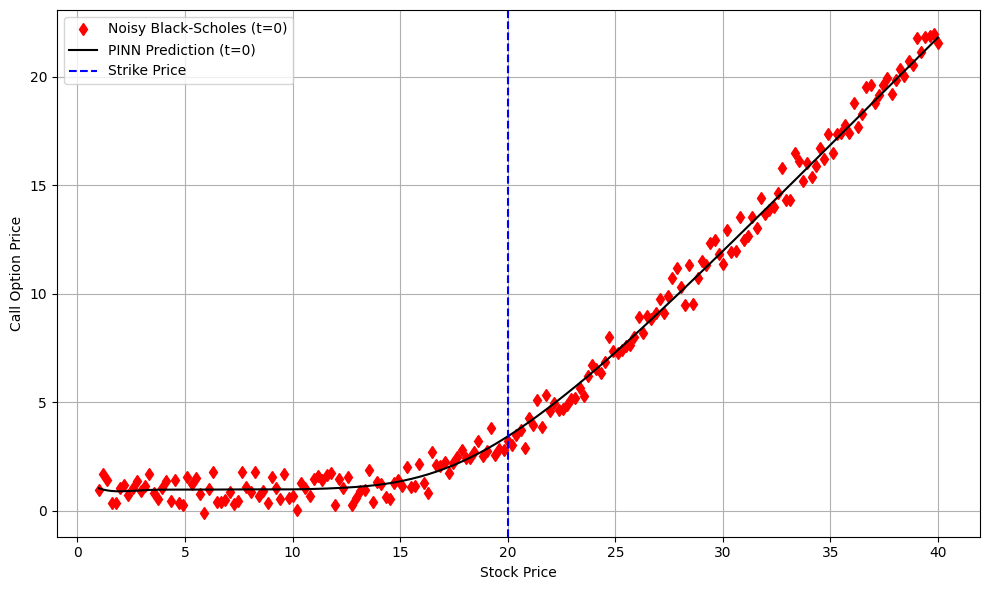

Mean Squared Error (MSE): 91.32322643732738


In [10]:
import matplotlib.pyplot as plt

S_np = S_eval.numpy().flatten()
epsilon = 1e-8 # Small constant to prevent division by zero
C_true = black_scholes_solution(S_np, config["K"], config["T"]- t + epsilon , config["r"], config["sigma"])
C_true += np.random.normal(config["bias"] , config["noise_variance"], size=C_true.shape)
plt.figure(figsize=(10, 6))
plt.plot(S_np, C_true, 'd', label="Noisy Black-Scholes (t=0)",color='red')
plt.plot(S_np, C_pred, label="PINN Prediction (t=0)", color='k')
plt.axvline(x=config["K"], color='blue', linestyle='--', label=f"Strike Price")

plt.xlabel('Stock Price')
plt.ylabel('Call Option Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse = np.mean((C_true - C_pred) ** 2)
print(f"Mean Squared Error (MSE): {mse}")